# 1. Projekat iz predmeta Mašinsko učenje

Klasifikacija po karakteristikama zemlje

Marija Cvetković 1940

Luka Kocić 2022

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold


In [3]:
df = pd.read_csv("input.csv")

## 1. Analiza podataka

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Soil_ID                            1000000 non-null  int64  
 1   Location_Latitude                  1000000 non-null  float64
 2   Location_Longitude                 1000000 non-null  float64
 3   Depth_cm                           1000000 non-null  float64
 4   Texture                            1000000 non-null  object 
 5   pH                                 1000000 non-null  float64
 6   Organic_Matter_%                   1000000 non-null  float64
 7   Moisture_Content_%                 1000000 non-null  float64
 8   Bulk_Density_g/cm³                 1000000 non-null  float64
 9   Nitrogen_N_ppm                     1000000 non-null  float64
 10  Phosphorus_P_ppm                   1000000 non-null  float64
 11  Potassium_K_ppm          

In [5]:
df.describe()

,Soil_ID,Location_Latitude,Location_Longitude,Depth_cm,pH,Organic_Matter_%,Moisture_Content_%,Bulk_Density_g/cm³,Nitrogen_N_ppm,Phosphorus_P_ppm,Potassium_K_ppm,Cation_Exchange_Capacity_meq/100g,Electrical_Conductivity_dS/m,Porosity_%,Water_Holding_Capacity_%
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.060208,-0.187684,17.503013,6.499917,5.500164,19.994861,1.199857,102.580566,30.006634,249.875195,25.010037,2.550400,37.501472,40.007685
std,288675.278932,51.946403,103.865450,7.218743,1.443158,2.597949,8.664421,0.230871,56.307008,11.545974,86.561417,8.655487,1.414580,7.214270,11.543025
min,1.000000,-89.999907,-179.999864,5.000025,4.000002,1.000005,5.000010,0.800001,5.000091,10.000015,100.000731,10.000014,0.100002,25.000007,20.000019
25%,250000.750000,-44.938762,-90.001356,11.251265,5.250710,3.249001,12.486926,1.000106,53.783290,20.005635,174.915582,17.507778,1.325367,31.253352,30.020650
50%,500000.500000,0.100075,-0.376740,17.510242,6.497696,5.505274,19.994249,1.199780,102.658544,30.007883,249.891170,25.017909,2.551018,37.490635,40.026669
75%,750000.250000,45.017411,89.726932,23.753234,7.751155,7.746259,27.511794,1.399679,151.361938,40.006229,324.752201,32.502019,3.776592,43.749108,49.984317
max,1000000.000000,89.999697,179.999778,29.999947,8.999986,9.999999,34.999977,1.599999,199.999944,49.999991,399.999812,39.999965,4.999999,49.999993,59.999935


In [6]:
df['Texture'].value_counts()

Texture
sandy     333463
loamy     333363
clayey    333174
Name: count, dtype: int64

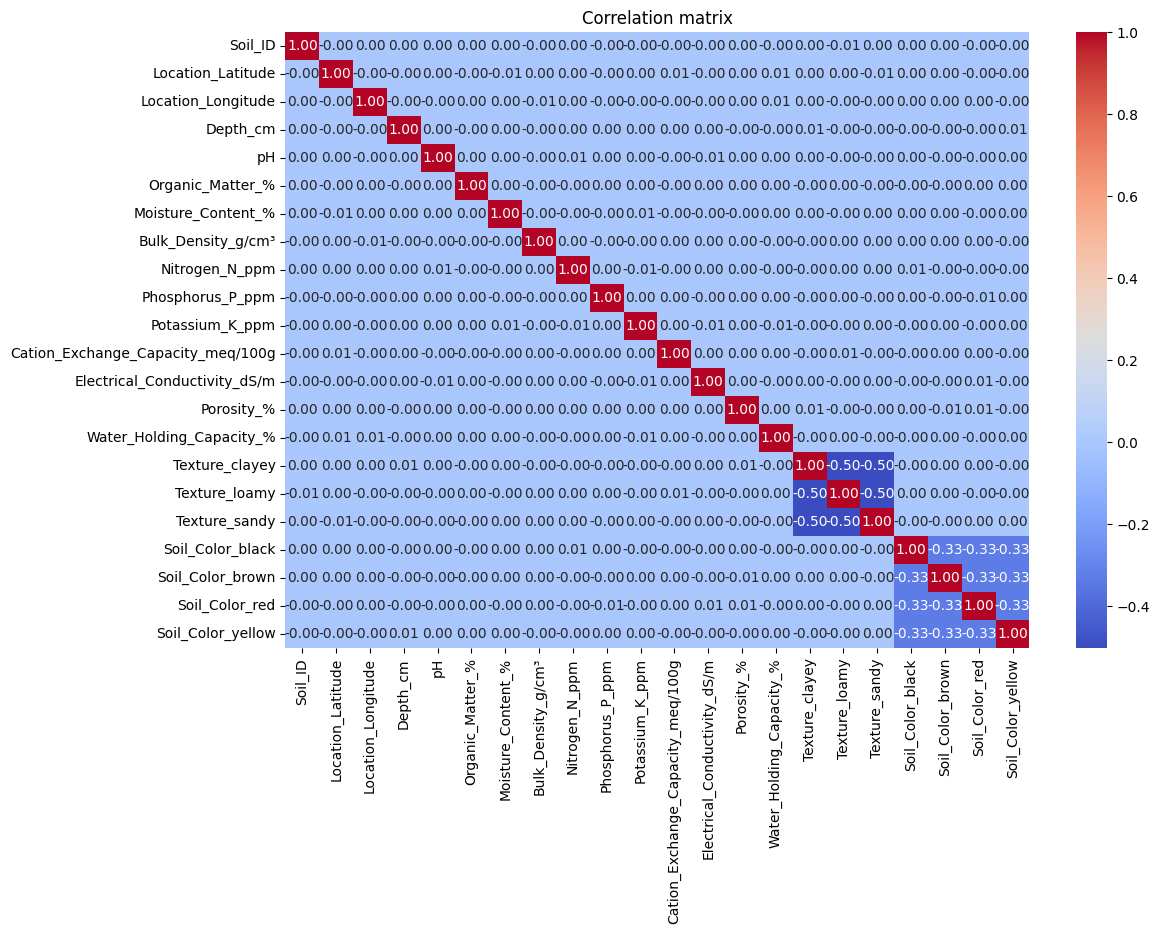

In [7]:
df_small = df.sample(frac=0.1, random_state=1)

df_new = df_small.copy()

# One-hot encoding

df_new = pd.get_dummies(df_small, columns=['Texture', 'Soil_Color'], prefix=['Texture', 'Soil_Color'])

plt.figure(figsize=(12, 8))
sns.heatmap(df_new.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

## 2. Deskriptivna analiza i čišćenje podataka

In [8]:
df.isnull().sum()

Soil_ID                              0
Location_Latitude                    0
Location_Longitude                   0
Depth_cm                             0
Texture                              0
pH                                   0
Organic_Matter_%                     0
Moisture_Content_%                   0
Bulk_Density_g/cm³                   0
Nitrogen_N_ppm                       0
Phosphorus_P_ppm                     0
Potassium_K_ppm                      0
Cation_Exchange_Capacity_meq/100g    0
Electrical_Conductivity_dS/m         0
Soil_Color                           0
Porosity_%                           0
Water_Holding_Capacity_%             0
dtype: int64

In [9]:
df.duplicated().any()

np.False_

In [10]:
df = df.drop_duplicates()

### Detekcija outlier-a


Box plot nad svim numerickim podacima

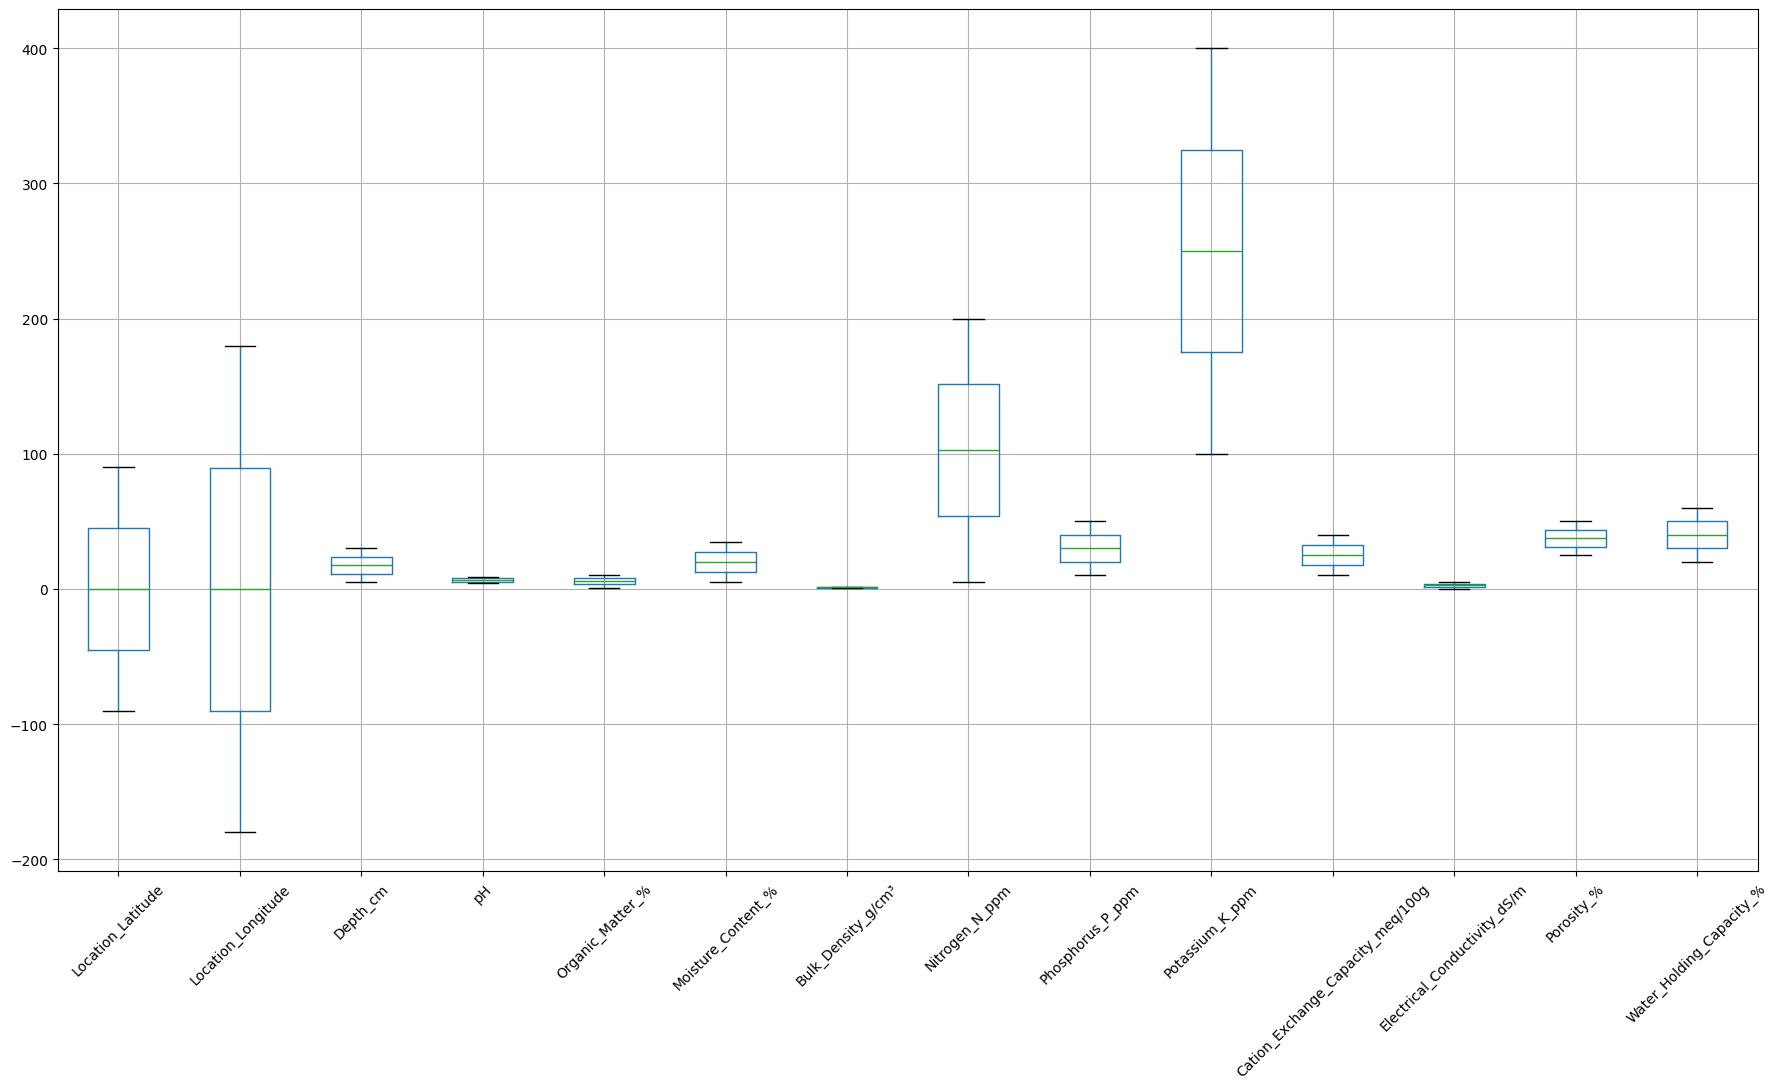

In [11]:
number_columns= df.select_dtypes(include='number').drop(columns=['Soil_ID'])
plt.figure(figsize=(18, 11))
number_columns.boxplot()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Vizualizacija outlier-a pomoću boxplot-a, scatter plot-a i histograma:

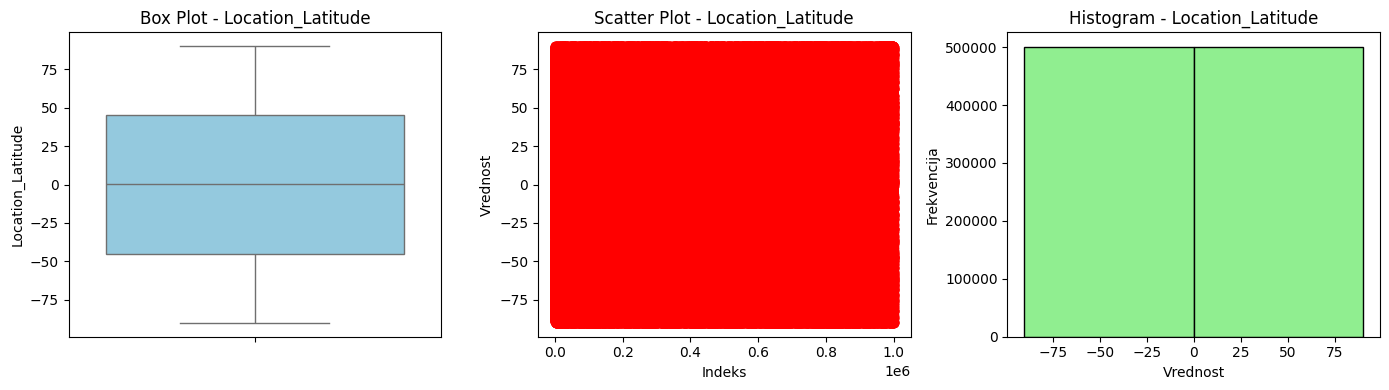

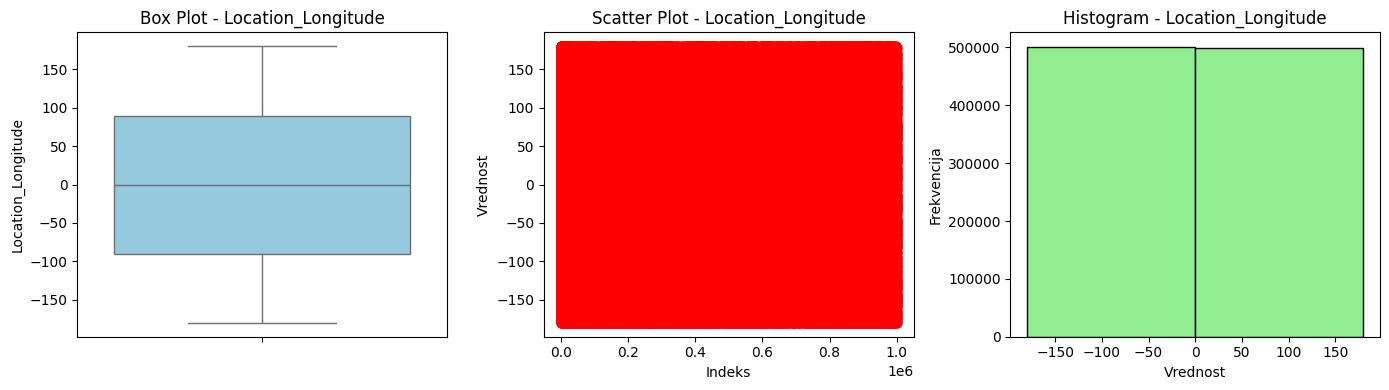

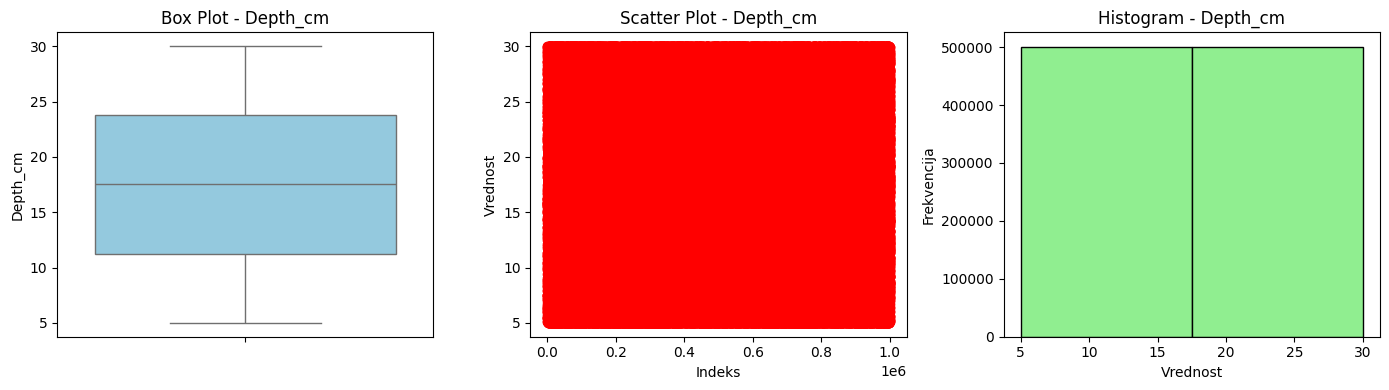

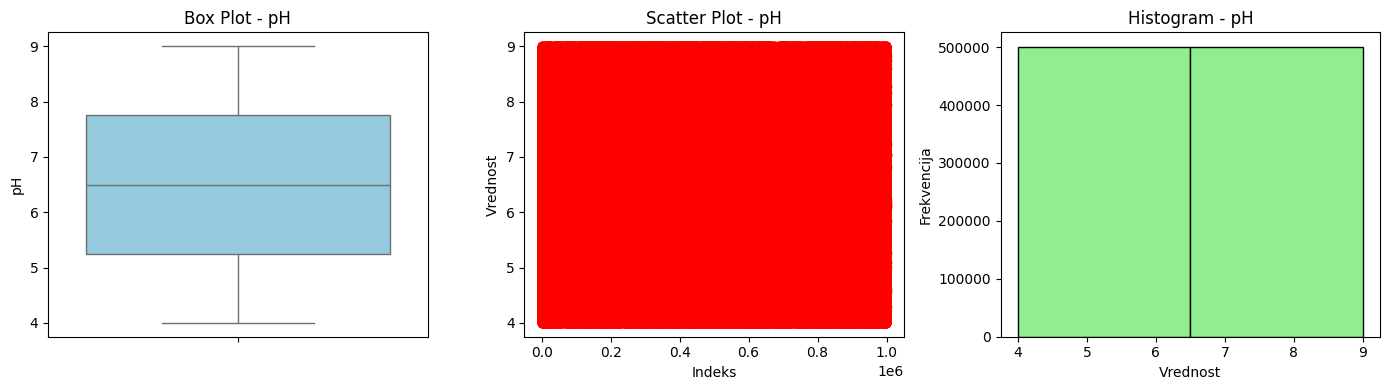

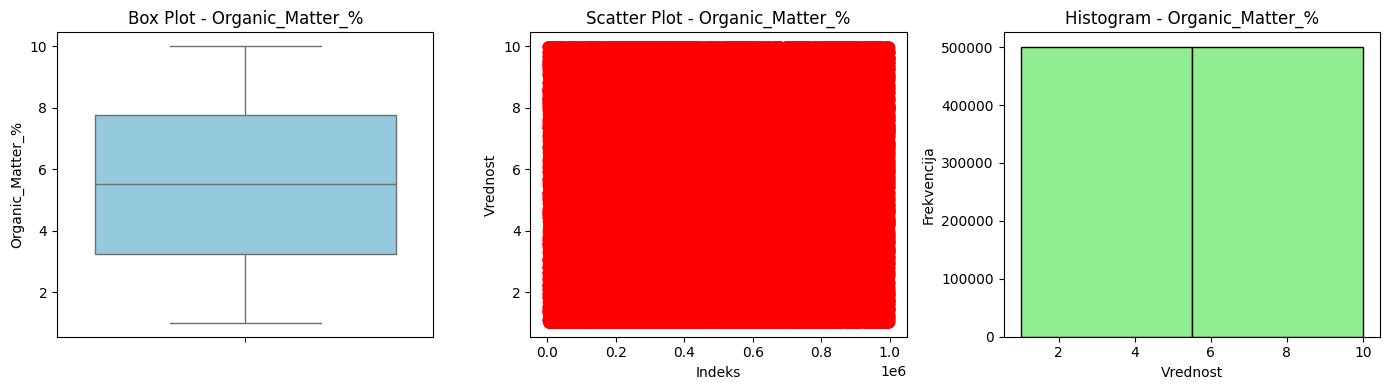

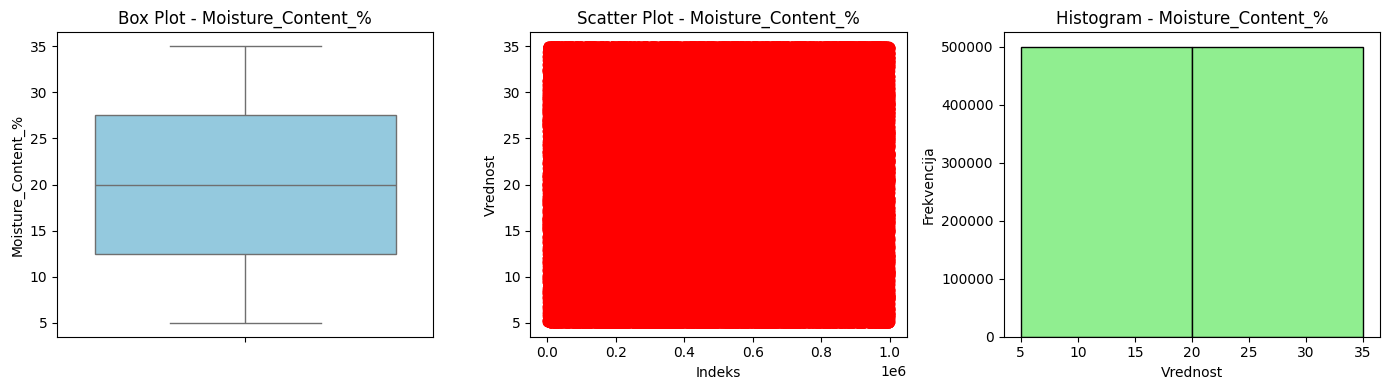

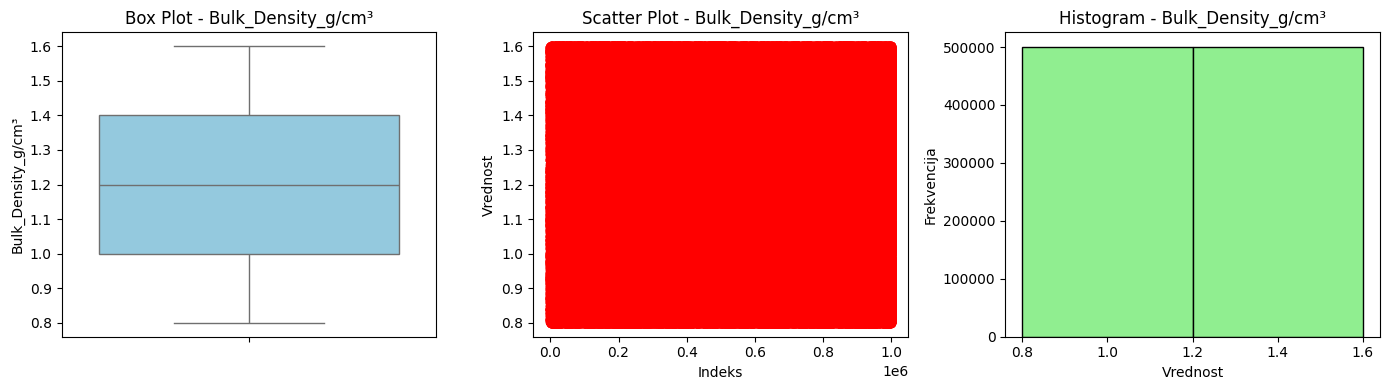

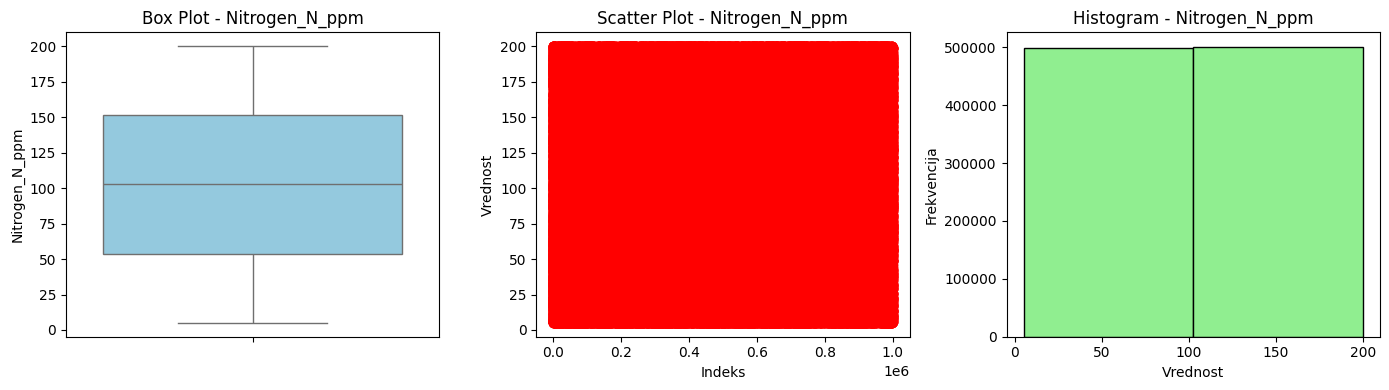

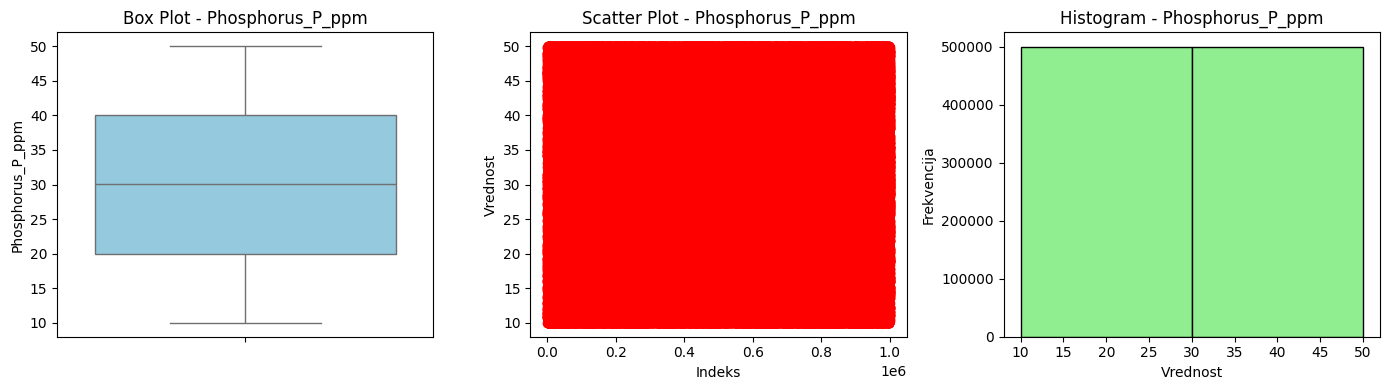

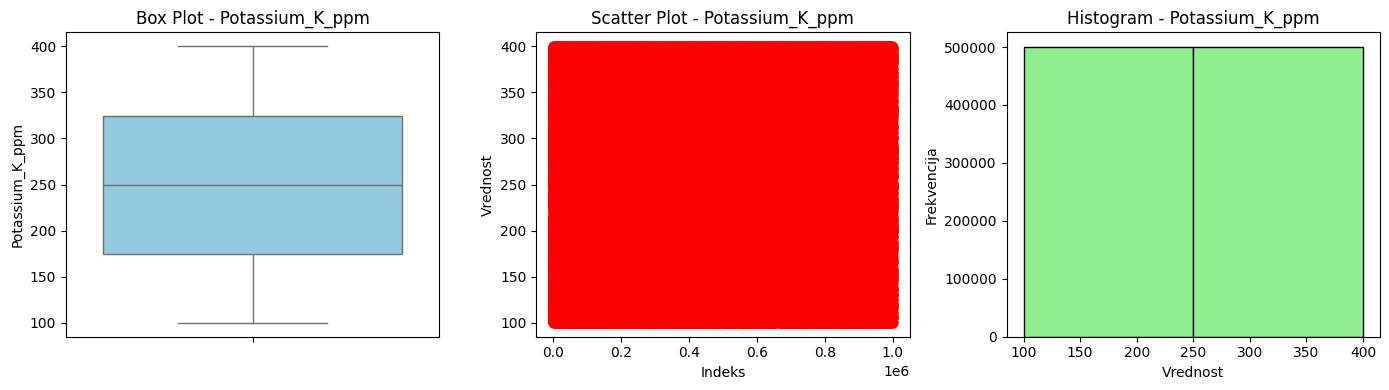

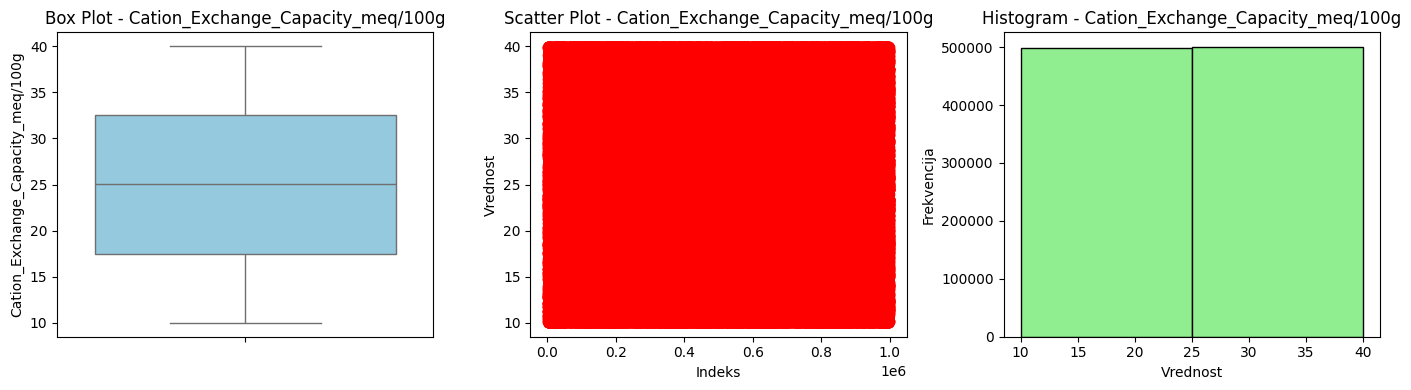

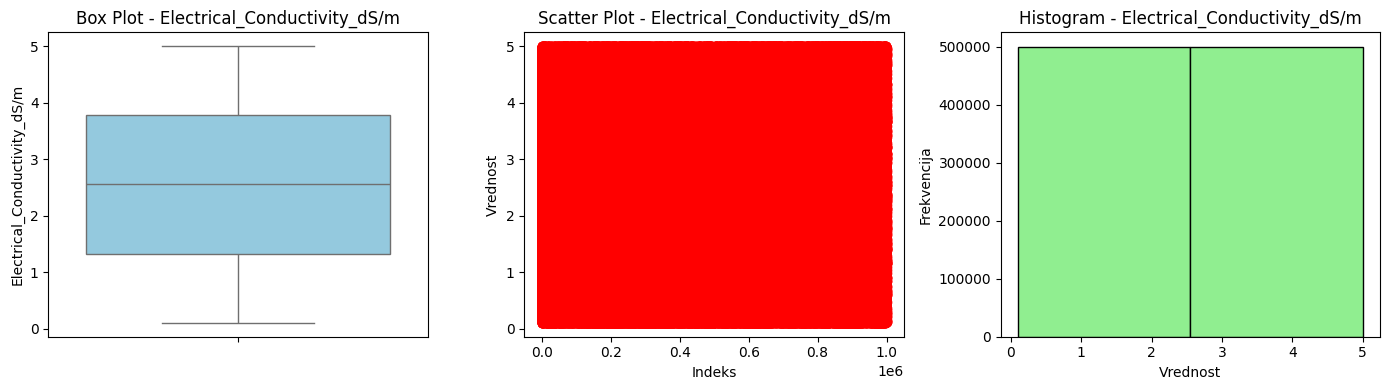

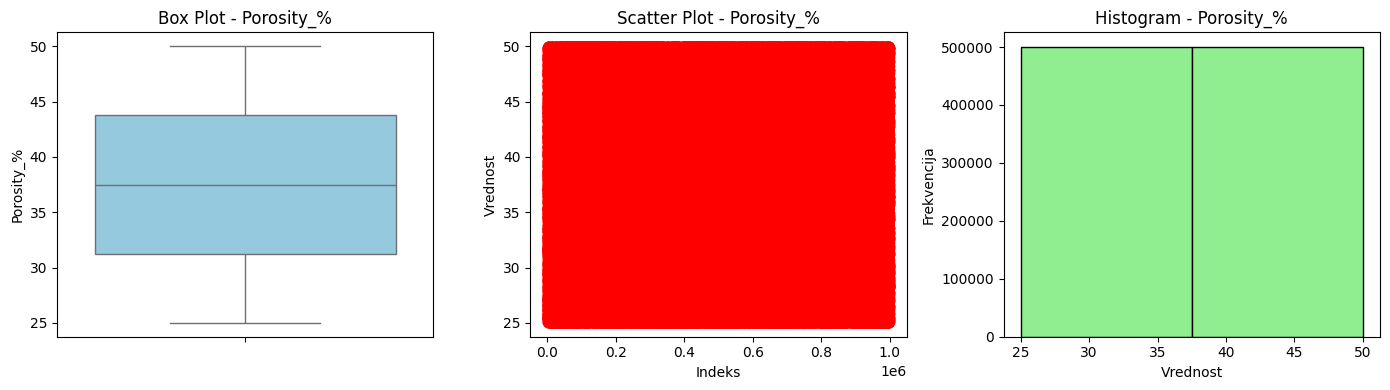

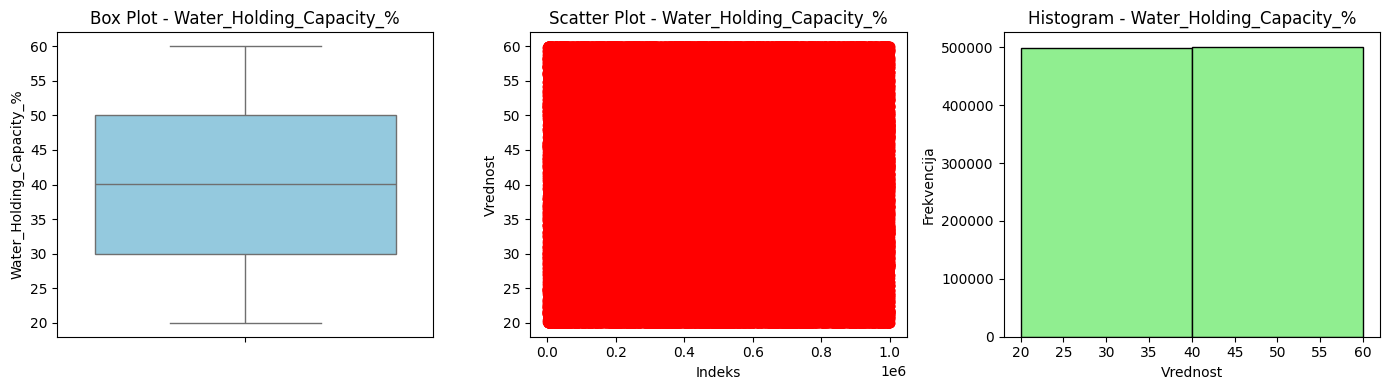

In [12]:
for column in number_columns.columns:
        plt.figure(figsize=(14, 4))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=2, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Primena IQR i Z_Score metode za detekciju outlier-a:

In [13]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")

        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)

        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: Location_Latitude ---
Outlieri po IQR metodi:
Empty DataFrame
Columns: [Soil_ID, Location_Latitude, Location_Longitude, Depth_cm, Texture, pH, Organic_Matter_%, Moisture_Content_%, Bulk_Density_g/cm³, Nitrogen_N_ppm, Phosphorus_P_ppm, Potassium_K_ppm, Cation_Exchange_Capacity_meq/100g, Electrical_Conductivity_dS/m, Soil_Color, Porosity_%, Water_Holding_Capacity_%]
Index: []
Outlieri po Z-Score metodi:
Empty DataFrame
Columns: [Soil_ID, Location_Latitude, Location_Longitude, Depth_cm, Texture, pH, Organic_Matter_%, Moisture_Content_%, Bulk_Density_g/cm³, Nitrogen_N_ppm, Phosphorus_P_ppm, Potassium_K_ppm, Cation_Exchange_Capacity_meq/100g, Electrical_Conductivity_dS/m, Soil_Color, Porosity_%, Water_Holding_Capacity_%]
Index: []

--- Kolona: Location_Longitude ---
Outlieri po IQR metodi:
Empty DataFrame
Columns: [Soil_ID, Location_Latitude, Location_Longitude, Depth_cm, Texture, pH, Organic_Matter_%, Moisture_Content_%, Bulk_Density_g/cm³, Nitrogen_N_ppm, Phosphorus_P_ppm, Po

Kao što vidimo i iz IQR i Z-Score metode ne postoje outlier-i.

## 3. Transformacija podataka

Pretvaranje tekstualnih vrednosti u numeričke: One-Hot Encoding metoda

In [14]:
df_encoded = pd.get_dummies(df, columns=['Soil_Color'], prefix=['Soil_Color'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Soil_ID                            1000000 non-null  int64  
 1   Location_Latitude                  1000000 non-null  float64
 2   Location_Longitude                 1000000 non-null  float64
 3   Depth_cm                           1000000 non-null  float64
 4   Texture                            1000000 non-null  object 
 5   pH                                 1000000 non-null  float64
 6   Organic_Matter_%                   1000000 non-null  float64
 7   Moisture_Content_%                 1000000 non-null  float64
 8   Bulk_Density_g/cm³                 1000000 non-null  float64
 9   Nitrogen_N_ppm                     1000000 non-null  float64
 10  Phosphorus_P_ppm                   1000000 non-null  float64
 11  Potassium_K_ppm          

In [15]:
df_encoded.iloc[0:10, 16:20]

,Soil_Color_black,Soil_Color_brown,Soil_Color_red,Soil_Color_yellow
0,False,False,True,False
1,False,False,False,True
2,False,False,False,True
3,True,False,False,False
4,True,False,False,False
5,False,False,True,False
6,True,False,False,False
7,False,False,False,True
8,False,False,False,True
9,False,True,False,False


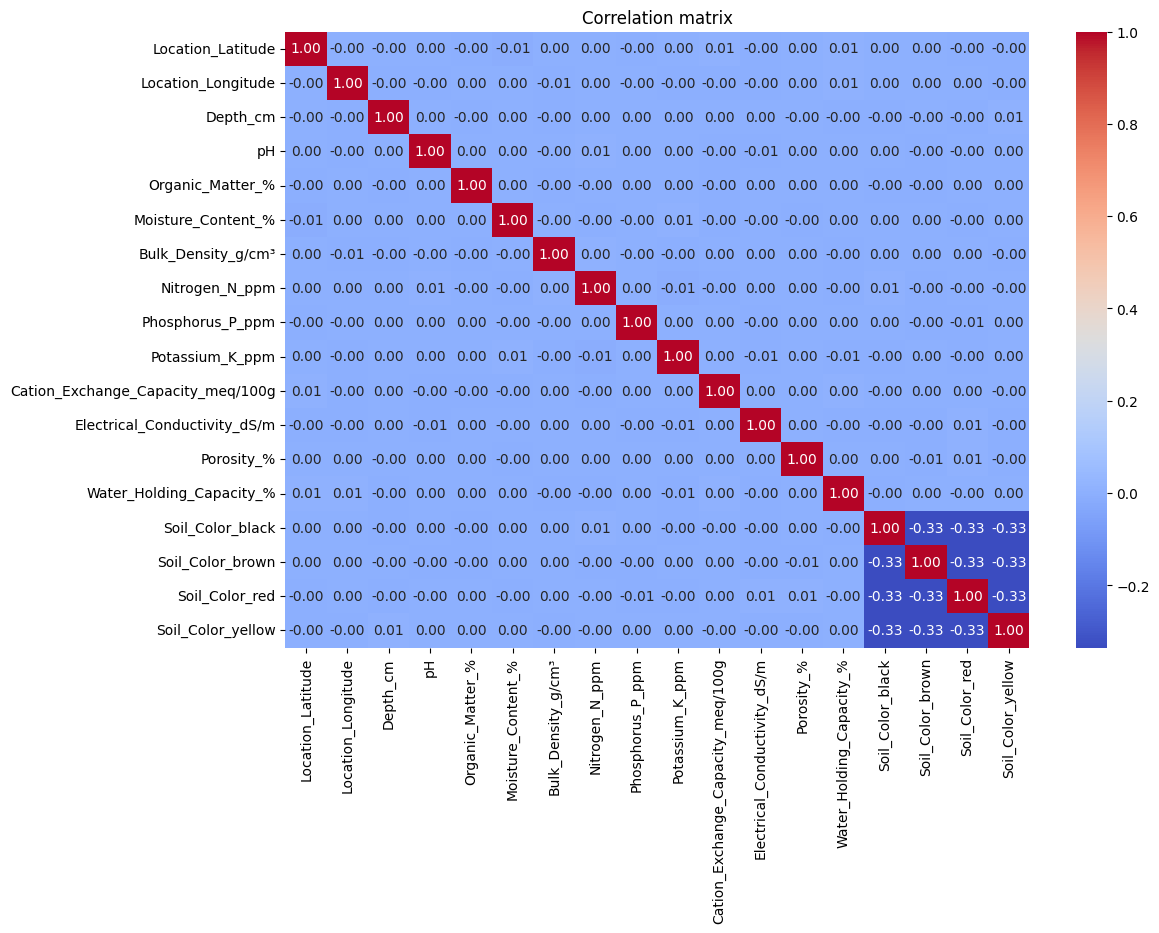

In [16]:
df_small = df_encoded.sample(frac=0.1, random_state=1).drop(columns=['Texture', 'Soil_ID'])

plt.figure(figsize=(12, 8))
sns.heatmap(df_small.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

## 4. Treniranje modela

### Random Forest

In [17]:
df_small = df_encoded.sample(frac=0.1, random_state=1)

le = LabelEncoder()
y = le.fit_transform(df_small['Texture'])

X = df_small.drop(
    ['Texture','Soil_ID'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

forest = RandomForestClassifier(random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
print(f"Accuracy: {forest.score(X_test, y_test)*100:.4f}%")

Accuracy: 33.0350%


In [18]:
X_data = df_small.drop(['Texture'], axis=1)
y_data = df_small[['Texture']]
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1)
print(X_train_data.shape)
print(X_test_data.shape)
print(y_train_data.shape)
print(y_test_data.shape)

(80000, 19)
(20000, 19)
(80000, 1)
(20000, 1)


In [19]:
cv=KFold(n_splits=5, shuffle=True, random_state=12)

# Random Forest sa skalomiranjem podataka

dtree_model=make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 0, n_jobs = -1))
score=cross_val_score(dtree_model, X_test_data, y_test_data, cv=cv, scoring="accuracy")
average=np.mean(score)
print(f"Average Cross Validation Accuracy:  {average*100:.2f}%")
print(f"Cross Validation Scores: {score}")

c:\Python312\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Python312\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Python312\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Python312\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(esti

Average Cross Validation Accuracy:  33.45%
Cross Validation Scores: [0.3355  0.33325 0.3355  0.33275 0.33525]


Izbacivanje longitude i latitude (accuracy se smanjuje)

In [20]:
df_no_latlng = df_encoded.drop(columns=['Location_Latitude', 'Location_Longitude'])

df_no_latlng_small = df_no_latlng.sample(frac=0.1, random_state=1)

le = LabelEncoder()
y = le.fit_transform(df_no_latlng_small['Texture'])

X = df_no_latlng_small.drop(
    ['Texture','Soil_ID'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

forest = RandomForestClassifier(random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
print(f"Accuracy: {forest.score(X_test, y_test)*100:.4f}%")

Accuracy: 33.6850%


### KNN

In [23]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

k_values = range(1, 50, 2)  # neparni K (da smanjiš šansu za nerešeno)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_k, best_score = None, -1
for k in k_values:
    pipe.set_params(knn__n_neighbors=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Najbolji K: {best_k}, CV accuracy: {best_score:.4f}")

pipe.set_params(knn__n_neighbors=best_k)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))



Najbolji K: 11, CV accuracy: 0.3359

Confusion matrix:
[[2723 2188 1747]
 [2754 2207 1767]
 [2669 2182 1763]]

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.41      0.37      6658
           1       0.34      0.33      0.33      6728
           2       0.33      0.27      0.30      6614

    accuracy                           0.33     20000
   macro avg       0.33      0.33      0.33     20000
weighted avg       0.33      0.33      0.33     20000



In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

# 3) GridSearch + cross-validation
param_grid = {
    "svm__kernel": ["linear", "rbf"],
    "svm__C": [ 1, 10],
    "svm__gamma": ["scale", 0.01]  # samo za rbf
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

print("Najbolji parametri:", grid.best_params_)
print("CV accuracy:", grid.best_score_)

# 4) Evaluacija na test setu
y_pred = grid.predict(X_test)

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

## 4. Optimizacija hiperparametra